## BatchNormalization
* Gradient Vanishing
    * 그래디언트가 너무 작아져서 학습에 문제가 생김
    
* Gradient Exploding
    * 그래디언트가 너무 커져서 학습에 문제가 생김

* Gradient Vanishing, Exploding 간접적인 해결 방법
    * Change activation function : sigmoid -> relu
    * Careful initialization : weight initialization (He, Xavier..)
    * Small learning rate : learning rate를 줄여서 최대한 exploding을 줄일 수 있음 

* Batch Normalization : 직접적인 해결방법 
    * Gradient Vanishing, Exploding 해결
    * 학습과정이 전반적으로 안정화
    * Dropout과 같은 regulation 효과

* Internal Covariate Shift : Gradient Vanishing과 Exploding을 만드는 요소 
    * train셋과 test셋의 분포의 차이로 학습에 문제가 생김
    * deep learning의 경우 각각의 layer를 거칠때마다 Covariate Shift가 발생 : internal Covariate Shift
    

In [1]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [3]:
# parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 128

In [4]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [5]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [6]:
# torch.nn layers
linear1 = torch.nn.Linear(784, 1000, bias=True)
linear2 = torch.nn.Linear(1000, 1000, bias=True)
linear3 = torch.nn.Linear(1000, 10, bias=True)

nn_linear1 = torch.nn.Linear(784, 1000, bias=True)
nn_linear2 = torch.nn.Linear(1000, 1000, bias=True)
nn_linear3 = torch.nn.Linear(1000, 10, bias=True)

ln_linear1 = torch.nn.Linear(784, 1000, bias=True)
ln_linear2 = torch.nn.Linear(1000, 1000, bias=True)
ln_linear3 = torch.nn.Linear(1000, 10, bias=True)

# activation
relu = torch.nn.ReLU()

# batch normalization
bn1 = torch.nn.BatchNorm1d(1000)
bn2 = torch.nn.BatchNorm1d(1000)

# layer normalization
ln1 = torch.nn.LayerNorm(1000)
ln2 = torch.nn.LayerNorm(1000)

In [7]:
# model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)

ln_model = torch.nn.Sequential(ln_linear1, ln1, relu,
                            ln_linear2, ln2, relu,
                            ln_linear3).to(device)

nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [8]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)
ln_optimizer = torch.optim.Adam(ln_model.parameters(), lr=learning_rate)

In [9]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode
    ln_model.train()
    
    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)
        
        # BN 역전파
        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()
        
        # BN 역전파
        ln_optimizer.zero_grad()
        ln_prediction = ln_model(X)
        ln_loss = criterion(ln_prediction, Y)
        ln_loss.backward()
        ln_optimizer.step()
        
        # NN 역전파
        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode
        ln_model.eval()
        
        # Test the model using train sets
        bn_loss, ln_loss, nn_loss, bn_acc, ln_acc, nn_acc = 0, 0, 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()
            
            ln_prediction = ln_model(X)
            ln_correct_prediction = torch.argmax(ln_prediction, 1) == Y
            ln_loss += criterion(ln_prediction, Y)
            ln_acc += ln_correct_prediction.float().mean()
            
            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, ln_loss, nn_loss = bn_loss / train_total_batch, ln_loss / train_total_batch , nn_loss / train_total_batch
        bn_acc, ln_acc, nn_acc = bn_acc / train_total_batch, ln_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, ln_loss, nn_loss])
        train_accs.append([bn_acc, ln_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] BN Loss(Acc): bn_loss:%.5f(bn_acc:%.2f)| LN Loss(Acc): ln_loss:%.5f(ln_acc:%.2f) | NN Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), ln_loss.item(), ln_acc.item() ,nn_loss.item(), nn_acc.item()))
       
        
        # Test the model using test sets
        bn_loss, ln_loss, nn_loss, bn_acc, ln_acc, nn_acc = 0, 0, 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()
            
            ln_prediction = ln_model(X)
            ln_correct_prediction = torch.argmax(ln_prediction, 1) == Y
            ln_loss += criterion(ln_prediction, Y)
            ln_acc += ln_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, ln_loss, nn_loss = bn_loss / test_total_batch, ln_loss / test_total_batch, nn_loss / test_total_batch
        bn_acc, ln_acc, nn_acc =  bn_acc / test_total_batch, ln_acc / test_total_batch , nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, ln_loss, nn_loss])
        valid_accs.append([bn_acc, ln_acc, nn_acc])
        print(
            '[Epoch %d-VALID] BN Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) | LN Loss(Acc): ln_loss:%.5f(ln_acc:%.2f) | NN Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), ln_loss.item(), ln_acc.item() ,nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] BN Loss(Acc): bn_loss:0.09745(bn_acc:0.97)| LN Loss(Acc): ln_loss:0.10064(ln_acc:0.97) | NN Loss(Acc): nn_loss:0.14491(nn_acc:0.96)
[Epoch 1-VALID] BN Loss(Acc): bn_loss:0.10903(bn_acc:0.96) | LN Loss(Acc): ln_loss:0.11010(ln_acc:0.97) | NN Loss(Acc): nn_loss:0.16682(nn_acc:0.95)

[Epoch 2-TRAIN] BN Loss(Acc): bn_loss:0.06245(bn_acc:0.98)| LN Loss(Acc): ln_loss:0.06295(ln_acc:0.98) | NN Loss(Acc): nn_loss:0.10429(nn_acc:0.97)
[Epoch 2-VALID] BN Loss(Acc): bn_loss:0.09692(bn_acc:0.97) | LN Loss(Acc): ln_loss:0.09045(ln_acc:0.97) | NN Loss(Acc): nn_loss:0.14033(nn_acc:0.96)

[Epoch 3-TRAIN] BN Loss(Acc): bn_loss:0.04217(bn_acc:0.99)| LN Loss(Acc): ln_loss:0.03820(ln_acc:0.99) | NN Loss(Acc): nn_loss:0.08768(nn_acc:0.97)
[Epoch 3-VALID] BN Loss(Acc): bn_loss:0.07418(bn_acc:0.98) | LN Loss(Acc): ln_loss:0.07666(ln_acc:0.98) | NN Loss(Acc): nn_loss:0.13427(nn_acc:0.96)

[Epoch 4-TRAIN] BN Loss(Acc): bn_loss:0.02598(bn_acc:0.99)| LN Loss(Acc): ln_loss:0.03128(ln_acc:0.99) | N

In [10]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    ln = [i[1] for i in loss_list]
    nn = [i[2] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(ln, label='With LN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

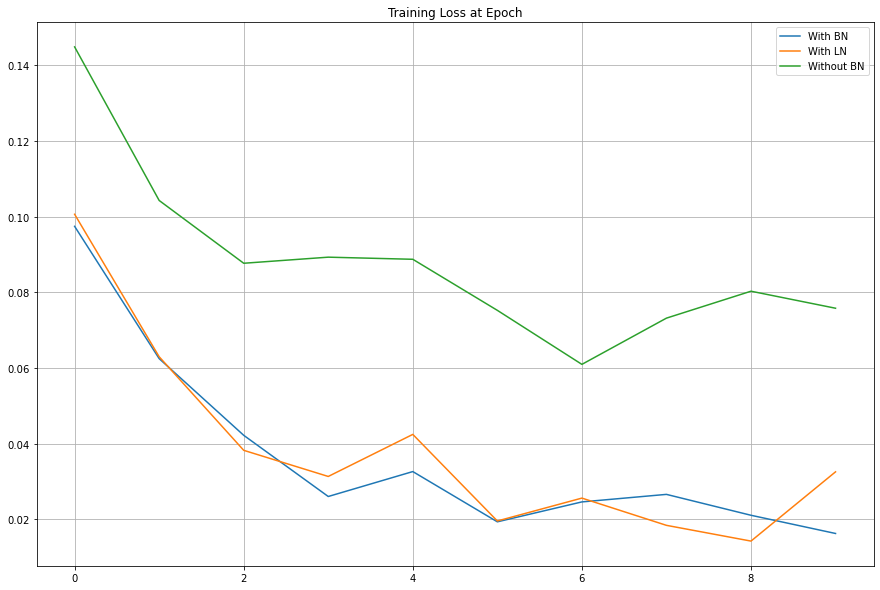

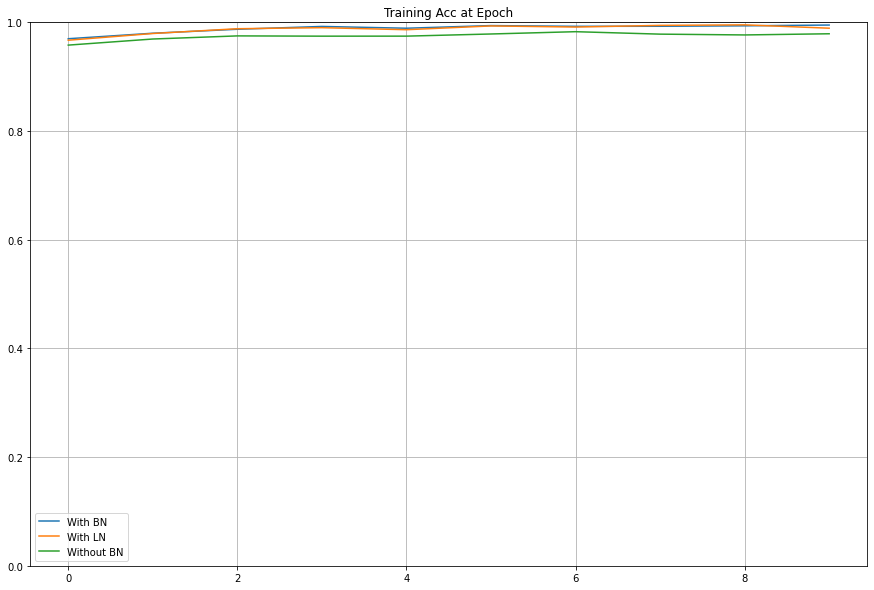

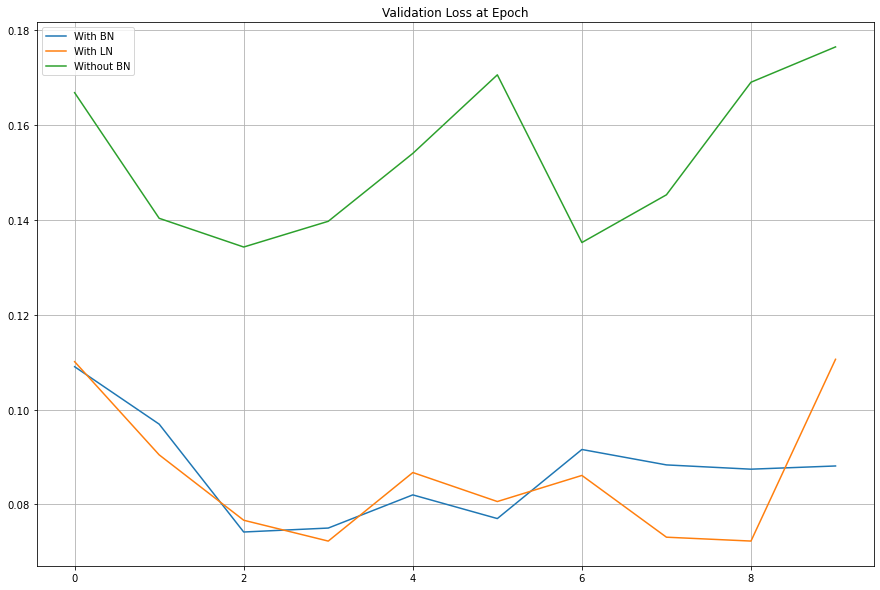

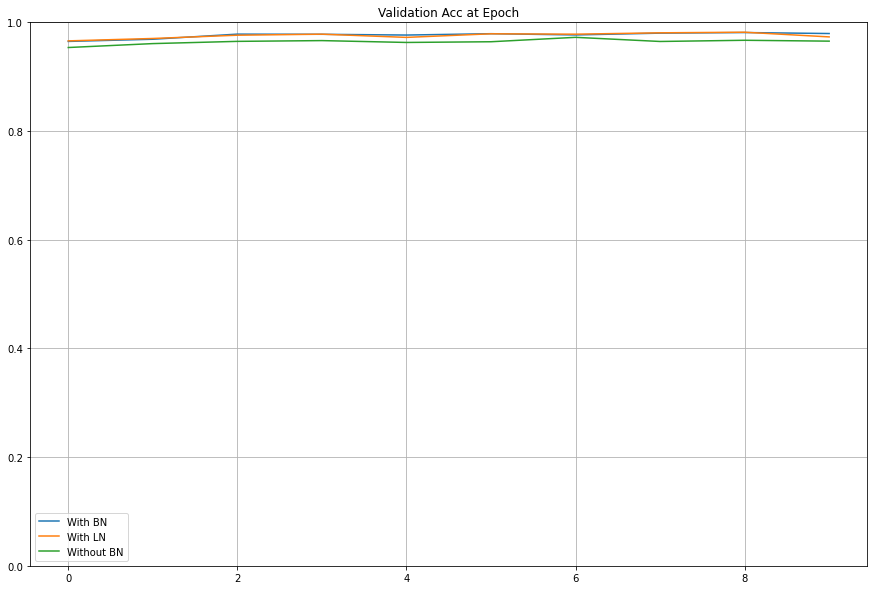

In [11]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')